# ANALYSIS OF METFORMIN CONTROL

This notebook contains an analysis of the effect of metformin on various tissues and organs as published in 


<img src="images/metformin-model-fits.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement

Metformin has proven effective at address type 2 diabetes. As such, there may be benefits if it is possible to maintain a constant dosage in physiological targets such as muscle. This is an exploratory study to investigate if the control of metformin in the blood (venus plasma) is sufficient to control metformin in muscle. This study considers a closed loop system in which: (a) metformin concentration is measured in muscle and (b) a controller can add metformin to the blood if its muscle concentration is low. We assume that there is no capability for removing metformin from the blood other than by physiological processes (e.g., intestinal absorption).

## Metformin Model

In [2]:
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
METFORMIN_SYS = ctl.SBMLSystem(url, input_names=["mPlasmaVenous"], output_names=["mMuscle"],
                               is_fixed_input_species=False)
#print(ctlsb.antimony)
METFORMIN_BUILDER = ctl.SISOTransferFunctionBuilder(METFORMIN_SYS)

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



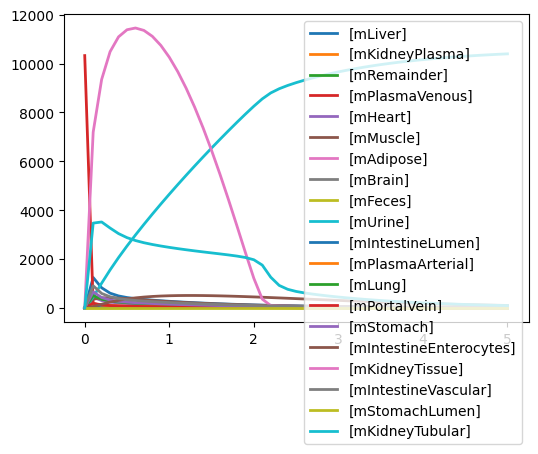

In [3]:
METFORMIN_SYS.roadrunner.simulate()
METFORMIN_SYS.roadrunner.plot()

# System Identification

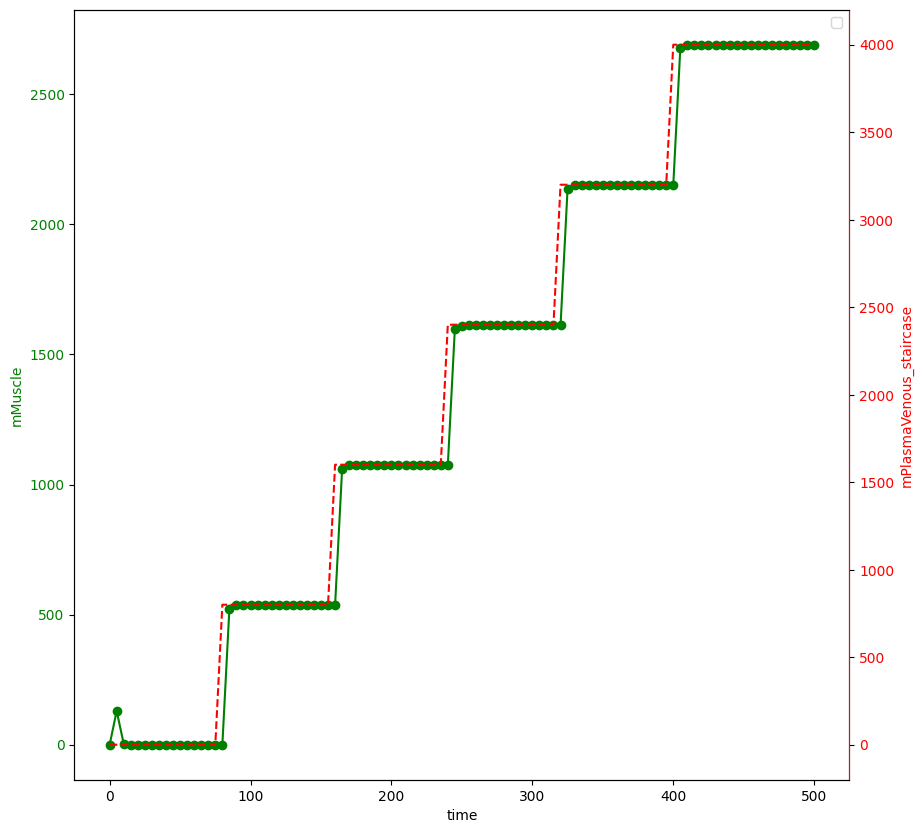

In [4]:
METFORMIN_STAIRCASE = ctl.Staircase(initial_value=0, final_value=4000, num_step=5)
response_ts = METFORMIN_BUILDER.makeStaircaseResponse(staircase=METFORMIN_STAIRCASE, end_time=500)
METFORMIN_BUILDER.plotStaircaseResponse(response_ts)

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

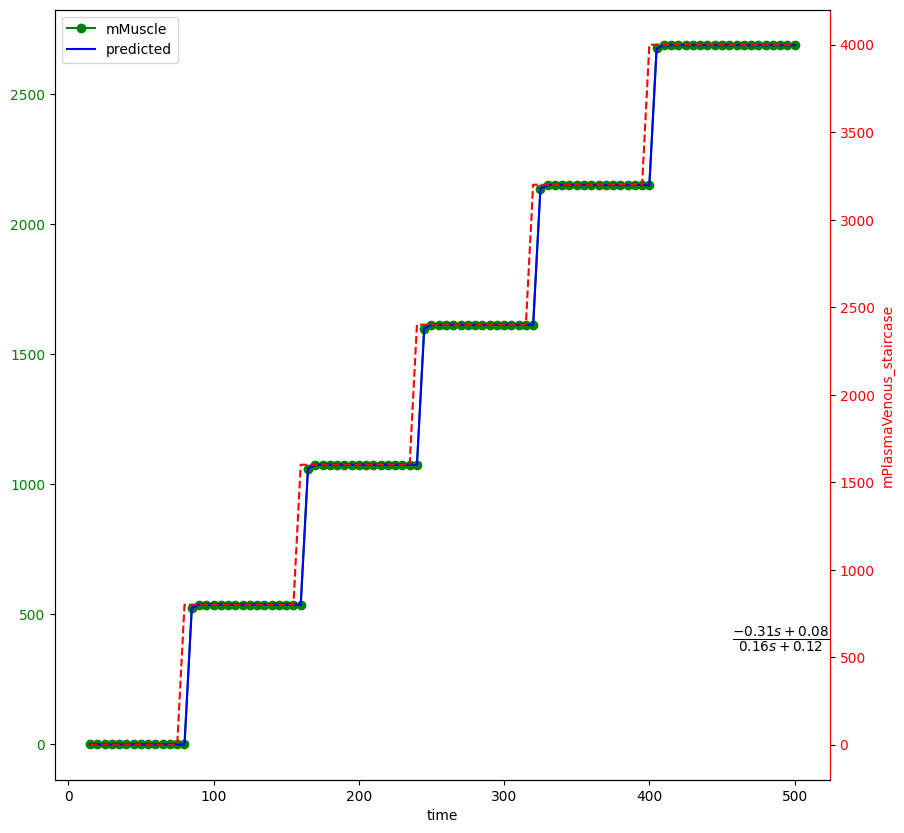

In [5]:
fitter_result = METFORMIN_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, 
                                                      staircase=METFORMIN_STAIRCASE, 
                                                      fit_start_time=10, start_time=0, end_time=500)
METFORMIN_BUILDER.plotFitTransferFunction(fitter_result)

In [6]:
fitter_result.rms_residuals

1.3708173863594213

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

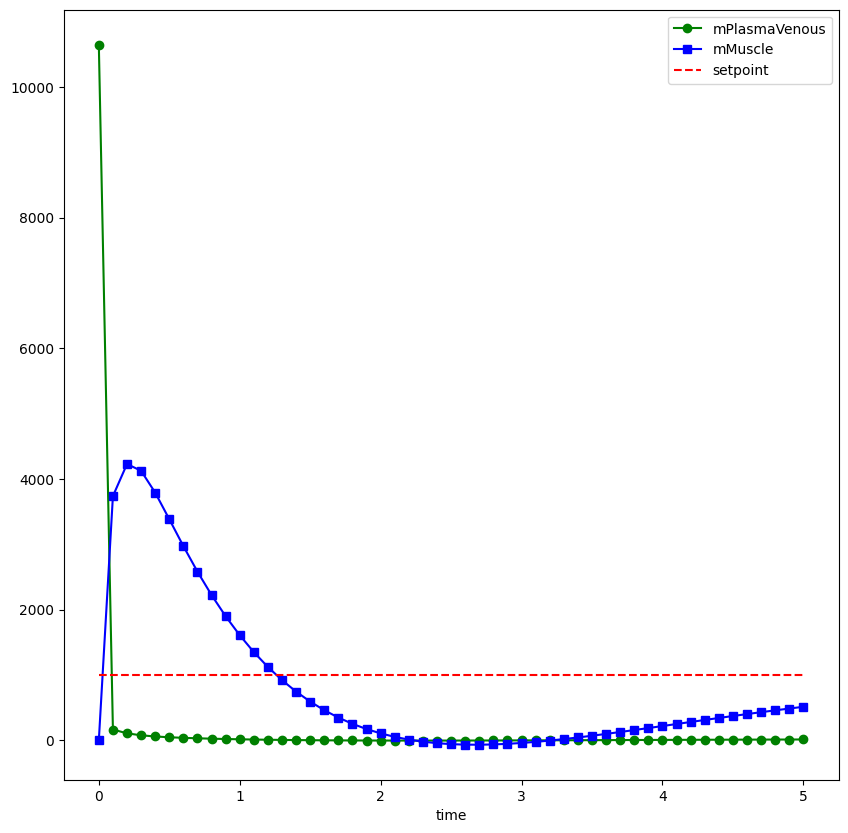

In [18]:
setpoint = 1e3
ts, builder = METFORMIN_SYS.simulateSISOClosedLoop(kp=1, ki=1, end_time=5, is_steady_state=True, setpoint=setpoint)
METFORMIN_SYS.plotSISOClosedLoop(ts, setpoint)

Objective: Minimize settling time subject to constraint that mPlasmaVenous and all floating species >= 0.
1. Approximate solution using transfer functions
2. Refine using simulations.

# Closed Loop Design and Evaluation